In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
# from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v6 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-18 13:11:08.295533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 13:11:08.295788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 13:11:08.331028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 13:11:08.331302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 13:11:08.331614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # data directory
    data_dir_idx = '005'
    
    # POD params
    num_latent_states = 32
    POD_data_with_params = False
    normalizeforPOD_flag = True
    normalization_type_POD = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier_POD = 3
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading data directory
    with open(dir_name_rnn + '/POD_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_data = params_dict['dir_name_data']
    data_dir_idx = dir_name_data[-3:]
    num_latent_states = params_dict['num_latent_states']
    POD_data_with_params = params_dict['POD_data_with_params']
    normalizeforPOD_flag = params_dict['normalizeforPOD_flag']
    normalization_type_POD = params_dict['normalization_type_POD']
    stddev_multiplier_POD = params_dict['stddev_multiplier_POD']
    normalization_constant_arr_PODdata = params_dict['normalization_constant_arr_PODdata']

    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data_POD.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data_POD.npz', allow_pickle=True)
        normalization_constant_arr_PODdata = fl['normalization_constant_arr_PODdata'][0]
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_arr = fl['normalization_arr'][0]

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data'].astype(FTYPE)
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']
        
print('dir_name_rnn:', dir_name_rnn)
print('data_dir_idx:', data_dir_idx)

normalize_flag_ogdata: False
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010
data_dir_idx: 005


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

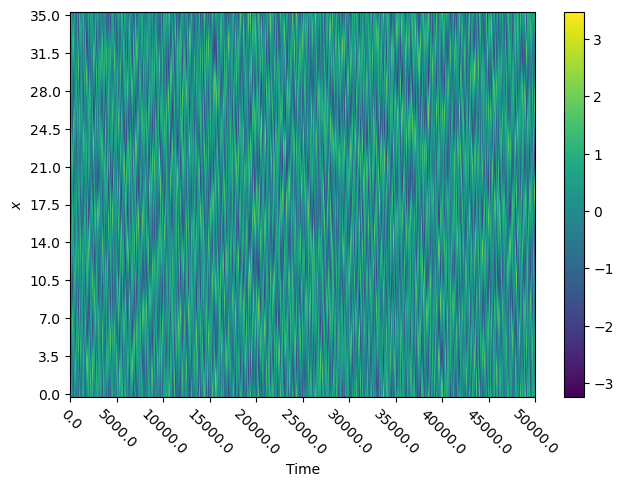

In [15]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [17]:
# dealing with normalizing the data before feeding into POD
if behaviour == 'initialiseAndTrainFromScratch':
    normalization_constant_arr_PODdata = None
    if normalizeforPOD_flag == True:
        normalization_constant_arr_PODdata = np.empty(shape=(2, numpoints_xgrid), dtype=FTYPE)
        if normalization_type_POD == 'stddev':
            for i in range(numpoints_xgrid):
                sample_mean = np.mean(all_data[:, i])
                sample_std = np.std(all_data[:, i])
                normalization_constant_arr_PODdata[0, i] = sample_mean
                normalization_constant_arr_PODdata[1, i] = stddev_multiplier_POD*sample_std
        elif normalization_type_POD == 'minmax':
            for i in range(numpoints_xgrid):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_PODdata[0, i] = sample_min
                normalization_constant_arr_PODdata[1, i] = sample_max - sample_min
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_PODdata[0, i]
            all_data[:, i] /= normalization_constant_arr_PODdata[1, i]

    if POD_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
            
    # saving sim data
    POD_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforPOD_flag':normalizeforPOD_flag,
        'normalization_constant_arr_PODdata':normalization_constant_arr_PODdata,
        'normalization_type_POD':normalization_type_POD,
        'stddev_multiplier_POD':stddev_multiplier_POD,
        'POD_data_with_params':POD_data_with_params,
        'num_latent_states':num_latent_states,
    }
    with open(dir_name_rnn+dir_sep+'POD_data.txt', 'w') as f:
        f.write(str(POD_data))
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data_POD',
        normalization_constant_arr_PODdata=[normalization_constant_arr_PODdata],
    )
else:
    if normalizeforPOD_flag == True:
        if POD_data_with_params == False:
            all_data = all_data[:, 0:numpoints_xgrid]
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_PODdata[0, i]
            all_data[:, i] /= normalization_constant_arr_PODdata[1, i]

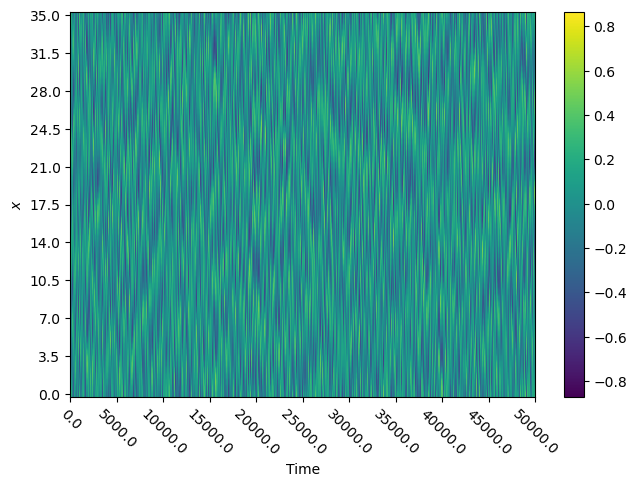

In [18]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto
)

# POD

In [19]:
cov_matrix = all_data.transpose() @ all_data
cov_matrix /= numpoints_xgrid-1

In [20]:
eigenvals, eigenvecs = linalg.eig(cov_matrix)

In [21]:
sorted_idx = np.argsort(eigenvals)
eigenvals = eigenvals[sorted_idx]
eigenvecs = eigenvecs[:, sorted_idx]

In [22]:
Wl = eigenvecs[:, -num_latent_states:]
latent_states_all = all_data @ Wl

In [23]:
del(all_data)

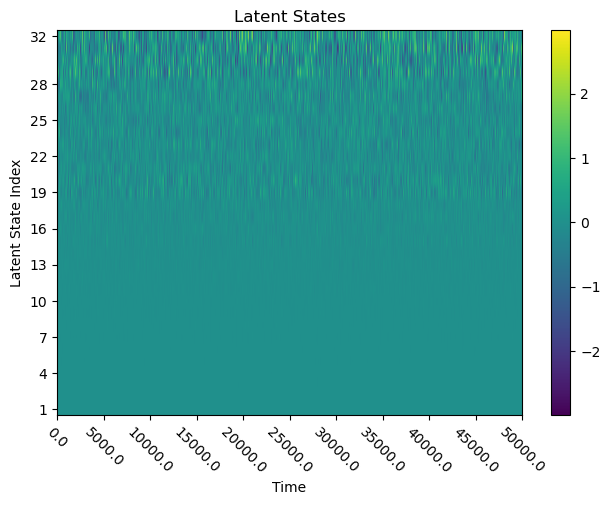

In [28]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_rnn,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=False)

# GRU

In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'uniform'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    dense_layer_act_func = ['linear']
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [33]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [34]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [35]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [36]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [37]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

del(idx)

In [38]:
print('training_data shape : ', training_data_rnn_input.shape)
print('testing_data shape : ', testing_data_rnn_input.shape)
print('val_data shape : ', val_data_rnn_input.shape)

training_data shape :  (515, 387, 32)
testing_data shape :  (65, 387, 32)
val_data shape :  (64, 387, 32)


In [39]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**9]*1
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.4685259
stddev : 0.011713147163391113


In [40]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [41]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
9/9 [==============================] - ETA: 0s - loss: 0.1349 - tot_time: 0h 1m 26.6s

Epoch 1: val_loss improved from inf to 0.08519, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 86s 2s/step - loss: 0.1349 - val_loss: 0.0852
Epoch 2/1000
9/9 [==============================] - ETA: 0s - loss: 0.0761 - tot_time: 0h 1m 30.2s

Epoch 2: val_loss improved from 0.08519 to 0.07331, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docu

Epoch 18/1000
9/9 [==============================] - ETA: 0s - loss: 0.0500 - tot_time: 0h 2m 27.5s

Epoch 18: val_loss improved from 0.05038 to 0.04946, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 399ms/step - loss: 0.0500 - val_loss: 0.0495
Epoch 19/1000
9/9 [==============================] - ETA: 0s - loss: 0.0495 - tot_time: 0h 2m 31.1s

Epoch 19: val_loss did not improve from 0.04946
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0495 - val_loss: 0.0503
Epoch 20/1000
9/9 [==============================] - ETA: 0s - loss: 0.0493 - tot_time: 0h 2m 34.5s

Epoch 20: val_loss improved from 0.04946 to 0.04854, saving model to /home/rka

Epoch 36/1000
9/9 [==============================] - ETA: 0s - loss: 0.0386 - tot_time: 0h 3m 31.7s

Epoch 36: val_loss improved from 0.03885 to 0.03821, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0386 - val_loss: 0.0382
Epoch 37/1000
9/9 [==============================] - ETA: 0s - loss: 0.0380 - tot_time: 0h 3m 35.3s

Epoch 37: val_loss improved from 0.03821 to 0.03760, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 406ms/step - loss: 0.0380 - val_loss: 0.0376
Epoch 38/1000
9/9 [==============================] - ETA: 0s - loss: 0.0374 

Epoch 54/1000
9/9 [==============================] - ETA: 0s - loss: 0.0297 - tot_time: 0h 4m 36.6s

Epoch 54: val_loss improved from 0.02993 to 0.02944, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0297 - val_loss: 0.0294
Epoch 55/1000
9/9 [==============================] - ETA: 0s - loss: 0.0292 - tot_time: 0h 4m 40.1s

Epoch 55: val_loss improved from 0.02944 to 0.02905, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0292 - val_loss: 0.0291
Epoch 56/1000
9/9 [==============================] - ETA: 0s - loss: 0.0289 

Epoch 72/1000
9/9 [==============================] - ETA: 0s - loss: 0.0236 - tot_time: 0h 5m 41.3s

Epoch 72: val_loss improved from 0.02380 to 0.02350, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0236 - val_loss: 0.0235
Epoch 73/1000
9/9 [==============================] - ETA: 0s - loss: 0.0233 - tot_time: 0h 5m 44.9s

Epoch 73: val_loss improved from 0.02350 to 0.02318, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 399ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 74/1000
9/9 [==============================] - ETA: 0s - loss: 0.0230 

Epoch 90/1000
9/9 [==============================] - ETA: 0s - loss: 0.0189 - tot_time: 0h 6m 46.0s

Epoch 90: val_loss improved from 0.01912 to 0.01886, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0189 - val_loss: 0.0189
Epoch 91/1000
9/9 [==============================] - ETA: 0s - loss: 0.0187 - tot_time: 0h 6m 49.6s

Epoch 91: val_loss improved from 0.01886 to 0.01877, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 404ms/step - loss: 0.0187 - val_loss: 0.0188
Epoch 92/1000
9/9 [==============================] - ETA: 0s - loss: 0.0185 

Epoch 108/1000
9/9 [==============================] - ETA: 0s - loss: 0.0153 - tot_time: 0h 7m 50.8s

Epoch 108: val_loss improved from 0.01547 to 0.01529, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 406ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 109/1000
9/9 [==============================] - ETA: 0s - loss: 0.0151 - tot_time: 0h 7m 54.3s

Epoch 109: val_loss improved from 0.01529 to 0.01515, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 110/1000
9/9 [==============================] - ETA: 0s - loss: 0.

Epoch 126/1000
9/9 [==============================] - ETA: 0s - loss: 0.0124 - tot_time: 0h 8m 55.6s

Epoch 126: val_loss improved from 0.01261 to 0.01249, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 404ms/step - loss: 0.0124 - val_loss: 0.0125
Epoch 127/1000
9/9 [==============================] - ETA: 0s - loss: 0.0123 - tot_time: 0h 8m 59.2s

Epoch 127: val_loss improved from 0.01249 to 0.01237, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 399ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 128/1000
9/9 [==============================] - ETA: 0s - loss: 0.

9/9 [==============================] - ETA: 0s - loss: 0.0103 - tot_time: 0h 10m 0.6s

Epoch 144: val_loss improved from 0.01048 to 0.01033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 402ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 145/1000
9/9 [==============================] - ETA: 0s - loss: 0.0101 - tot_time: 0h 10m 4.2s

Epoch 145: val_loss improved from 0.01033 to 0.01021, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 146/1000
9/9 [==============================] - ETA: 0s - loss: 0.0100 - tot_time

Epoch 162/1000
9/9 [==============================] - ETA: 0s - loss: 0.0084 - tot_time: 0h 11m 5.2s

Epoch 162: val_loss improved from 0.00863 to 0.00857, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 163/1000
9/9 [==============================] - ETA: 0s - loss: 0.0084 - tot_time: 0h 11m 8.8s

Epoch 163: val_loss improved from 0.00857 to 0.00854, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 164/1000
9/9 [==============================] - ETA: 0s - loss: 0.

Epoch 180/1000
9/9 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 12m 9.7s

Epoch 180: val_loss did not improve from 0.00719
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 181/1000
9/9 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 12m 13.3s

Epoch 181: val_loss improved from 0.00719 to 0.00709, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 402ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 182/1000
9/9 [==============================] - ETA: 0s - loss: 0.0069 - tot_time: 0h 12m 16.9s

Epoch 182: val_loss improved from 0.00709 to 0.00708, saving model to /

Epoch 199/1000
9/9 [==============================] - ETA: 0s - loss: 0.0059 - tot_time: 0h 13m 17.1s

Epoch 199: val_loss improved from 0.00613 to 0.00603, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 200/1000
9/9 [==============================] - ETA: 0s - loss: 0.0058 - tot_time: 0h 13m 20.7s

Epoch 200: val_loss improved from 0.00603 to 0.00598, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 399ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 201/1000
9/9 [==============================] - ETA: 0s - loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 400ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 218/1000
9/9 [==============================] - ETA: 0s - loss: 0.0049 - tot_time: 0h 14m 25.1s

Epoch 218: val_loss improved from 0.00506 to 0.00502, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 219/1000
9/9 [==============================] - ETA: 0s - loss: 0.0048 - tot_time: 0h 14m 28.7s

Epoch 219: val_loss did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/st

Epoch 237/1000
9/9 [==============================] - ETA: 0s - loss: 0.0043 - tot_time: 0h 15m 33.1s

Epoch 237: val_loss improved from 0.00444 to 0.00438, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 405ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 238/1000
9/9 [==============================] - ETA: 0s - loss: 0.0042 - tot_time: 0h 15m 36.8s

Epoch 238: val_loss improved from 0.00438 to 0.00436, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 239/1000
9/9 [==============================] - ETA: 0s - loss: 

Epoch 257/1000
9/9 [==============================] - ETA: 0s - loss: 0.0037 - tot_time: 0h 16m 44.7s

Epoch 257: val_loss improved from 0.00383 to 0.00383, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 258/1000
9/9 [==============================] - ETA: 0s - loss: 0.0037 - tot_time: 0h 16m 48.4s

Epoch 258: val_loss did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 259/1000
9/9 [==============================] - ETA: 0s - loss: 0.0036 - tot_time: 0h 16m 51.8s

Epoch 259: val_loss did not improve from 0.00383
 - saving loss histor

9/9 [==============================] - ETA: 0s - loss: 0.0034 - tot_time: 0h 17m 55.9s

Epoch 277: val_loss improved from 0.00347 to 0.00344, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 402ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 278/1000
9/9 [==============================] - ETA: 0s - loss: 0.0033 - tot_time: 0h 17m 59.5s

Epoch 278: val_loss improved from 0.00344 to 0.00336, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 279/1000
9/9 [==============================] - ETA: 0s - loss: 0.0032 - tot_ti

Epoch 297/1000
9/9 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 19m 7.2s

Epoch 297: val_loss did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 385ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 298/1000
9/9 [==============================] - ETA: 0s - loss: 0.0028 - tot_time: 0h 19m 10.7s

Epoch 298: val_loss did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 299/1000
9/9 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 19m 14.2s

Epoch 299: val_loss did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/

Epoch 318/1000
9/9 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 20m 21.9s

Epoch 318: val_loss did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 391ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 319/1000
9/9 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 20m 25.4s

Epoch 319: val_loss did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 320/1000
9/9 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 20m 29.0s

Epoch 320: val_loss improved from 0.00273 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histor

Epoch 339/1000
9/9 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 21m 36.4s

Epoch 339: val_loss did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 340/1000
9/9 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 21m 39.9s

Epoch 340: val_loss did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 390ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 341/1000
9/9 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 21m 43.5s

Epoch 341: val_loss improved from 0.00249 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histor

Epoch 360/1000
9/9 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 22m 50.8s

Epoch 360: val_loss did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 361/1000
9/9 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 22m 54.4s

Epoch 361: val_loss did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 362/1000
9/9 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 22m 57.9s

Epoch 362: val_loss did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 382/1000
9/9 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 24m 8.8s

Epoch 382: val_loss did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 392ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 383/1000
9/9 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 24m 12.4s

Epoch 383: val_loss did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 384/1000
9/9 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 24m 16.0s

Epoch 384: val_loss did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/

Epoch 403/1000
9/9 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 25m 23.5s

Epoch 403: val_loss did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 404/1000
9/9 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 25m 27.0s

Epoch 404: val_loss did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 393ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 405/1000
9/9 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 25m 30.5s

Epoch 405: val_loss did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 425/1000
9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 26m 41.3s

Epoch 425: val_loss did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 391ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 426/1000
9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 26m 44.9s

Epoch 426: val_loss did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 394ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 427/1000
9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 26m 48.4s

Epoch 427: val_loss did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 447/1000
9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 27m 59.4s

Epoch 447: val_loss did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 390ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 448/1000
9/9 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 28m 3.0s

Epoch 448: val_loss did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 449/1000
9/9 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 28m 6.5s

Epoch 449: val_loss did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9

Epoch 469/1000
9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 29m 17.0s

Epoch 469: val_loss did not improve from 0.00190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 470/1000
9/9 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 29m 20.5s

Epoch 470: val_loss did not improve from 0.00190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 397ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 471/1000
9/9 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 29m 24.0s

Epoch 471: val_loss did not improve from 0.00190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 30m 34.4s

Epoch 491: val_loss did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 492/1000
9/9 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 30m 38.0s

Epoch 492: val_loss did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 493/1000
9/9 [==============================] - ETA: 0s - loss: 0.0018 - tot_time: 0h 30m 41.5s

Epoch 493: val_loss did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [===========

Epoch 512/1000
9/9 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 31m 48.6s

Epoch 512: val_loss did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 513/1000
9/9 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 31m 52.1s

Epoch 513: val_loss did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 379ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 514/1000
9/9 [==============================] - ETA: 0s - loss: 0.0017 - tot_time: 0h 31m 55.5s

Epoch 514: val_loss did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 534/1000
9/9 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 33m 6.0s

Epoch 534: val_loss improved from 0.00176 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 404ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 535/1000
9/9 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 33m 9.6s

Epoch 535: val_loss did not improve from 0.00173
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 536/1000
9/9 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 33m 13.1s

Epoch 536: val_loss did not improve from 0.00173
 - saving loss historie

9/9 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 34m 23.6s

Epoch 556: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 382ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 557/1000
9/9 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 34m 27.1s

Epoch 557: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 389ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 558/1000
9/9 [==============================] - ETA: 0s - loss: 0.0016 - tot_time: 0h 34m 30.6s

Epoch 558: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [===========

Epoch 579/1000
9/9 [==============================] - ETA: 0s - loss: 0.0016Restoring model weights from the end of the best epoch: 554.
 - tot_time: 0h 35m 44.3s

Epoch 579: val_loss did not improve from 0.00172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 385ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 579: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
9/9 [==============================] - ETA: 0s - loss: 0.0015 - tot_time: 0h 35m 47.9s

Epoch 1: val_loss improved from 0.00172 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Document

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 18/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 48.7s

Epoch 18: val_loss did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 19/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 36m 52.2s

Epoch 19: val_loss did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 392ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 20/1000
9/9 [==============================] - ETA: 0s - loss: 0

9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 37m 56.0s

Epoch 37: val_loss did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 38/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 37m 59.5s

Epoch 38: val_loss did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 39/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 38m 3.1s

Epoch 39: val_loss did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [=================

Epoch 58/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 39m 9.9s

Epoch 58: val_loss did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 59/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 39m 13.3s

Epoch 59: val_loss improved from 0.00151 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 394ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 60/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 39m 16.9s

Epoch 60: val_loss did not improve from 0.00150
 - saving loss histories at 

Epoch 79/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 23.8s

Epoch 79: val_loss did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 392ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 80/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 27.3s

Epoch 80: val_loss did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 391ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 81/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 40m 30.7s

Epoch 81: val_loss did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==

Epoch 99/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 41m 34.2s

Epoch 99: val_loss did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 100/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 41m 37.7s

Epoch 100: val_loss improved from 0.00149 to 0.00149, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 101/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 41m 41.2s

Epoch 101: val_loss improved from 0.00149 to 0.00149, saving model to /h

Epoch 120/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 48.2s

Epoch 120: val_loss did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 388ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 121/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 51.7s

Epoch 121: val_loss did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 389ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 122/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 42m 55.2s

Epoch 122: val_loss did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 142/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 5.6s

Epoch 142: val_loss did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 386ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 143/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 9.1s

Epoch 143: val_loss improved from 0.00148 to 0.00148, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 402ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 144/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 44m 12.7s

Epoch 144: val_loss did not improve from 0.00148
 - saving loss historie

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 163/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 45m 19.7s

Epoch 163: val_loss did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 393ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 164/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 45m 23.3s

Epoch 164: val_loss did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 393ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 165/1000
9/9 [==============================] - ETA: 0s - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 184/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 33.5s

Epoch 184: val_loss did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 391ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 185/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 46m 37.0s

Epoch 185: val_loss did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 386ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 186/1000
9/9 [==============================] - ETA: 0s - lo

Epoch 205/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 47m 47.0s

Epoch 205: val_loss did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 206/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 47m 50.5s

Epoch 206: val_loss did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 395ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 207/1000
9/9 [==============================] - ETA: 0s - loss: 0.0014 - tot_time: 0h 47m 54.0s

Epoch 207: val_loss did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 227/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 49m 4.1s

Epoch 227: val_loss did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 384ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 228/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 49m 7.6s

Epoch 228: val_loss improved from 0.00147 to 0.00147, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 394ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 229/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 49m 11.1s

Epoch 229: val_loss did not improve from 0.00147
 - saving loss historie

Epoch 248/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 50m 17.6s

Epoch 248: val_loss did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 383ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 249/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 50m 21.1s

Epoch 249: val_loss did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 391ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 250/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 50m 24.6s

Epoch 250: val_loss did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 51m 34.6s

Epoch 270: val_loss did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 393ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 271/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 51m 38.1s

Epoch 271: val_loss improved from 0.00146 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 402ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 272/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 51m 41.6s

Epoch 272: val_loss did not improve from 0.00146
 - saving loss histories at /home/rk

Epoch 292/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 52m 51.6s

Epoch 292: val_loss did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 390ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 293/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 52m 55.1s

Epoch 293: val_loss did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 294/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 52m 58.6s

Epoch 294: val_loss did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

Epoch 314/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 54m 8.7s

Epoch 314: val_loss did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 391ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 315/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 54m 12.2s

Epoch 315: val_loss improved from 0.00145 to 0.00145, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 393ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 316/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 54m 15.7s

Epoch 316: val_loss did not improve from 0.00145
 - saving loss histori

Epoch 336/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 55m 25.6s

Epoch 336: val_loss did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 337/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 55m 29.1s

Epoch 337: val_loss did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 394ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 338/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 55m 32.6s

Epoch 338: val_loss did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9

9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 56m 42.7s

Epoch 358: val_loss did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 392ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 359/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 56m 46.2s

Epoch 359: val_loss did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 384ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 360/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 56m 49.7s

Epoch 360: val_loss improved from 0.00144 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rk

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 398ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 380/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 57m 59.8s

Epoch 380: val_loss did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 387ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 381/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 58m 3.3s

Epoch 381: val_loss did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 396ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 382/1000
9/9 [==============================] - ETA: 0s - los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 386ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 402/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 59m 16.6s

Epoch 402: val_loss did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 381ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 403/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 0h 59m 20.2s

Epoch 403: val_loss did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 394ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 404/1000
9/9 [==============================] - ETA: 0s - lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 399ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 424/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 0m 33.9s

Epoch 424: val_loss did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 393ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 425/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 0m 37.5s

Epoch 425: val_loss did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 392ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 426/1000
9/9 [==============================] - ETA: 0s - loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 407ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 1m 47.7s

Epoch 2: val_loss improved from 0.00141 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 401ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 1m 51.4s

Epoch 3: val_loss improved from 0.00141 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/r

Epoch 23/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 3m 1.7s

Epoch 23: val_loss did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 4s 391ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 24/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 3m 5.2s

Epoch 24: val_loss did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [==============================] - 3s 391ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 25/1000
9/9 [==============================] - ETA: 0s - loss: 0.0013 - tot_time: 1h 3m 8.7s

Epoch 25: val_loss did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_010/checkpoints/LossHistoriesCheckpoint
9/9 [========

In [42]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

3/3 [==============================] - 14s 118ms/step - loss: 0.0014


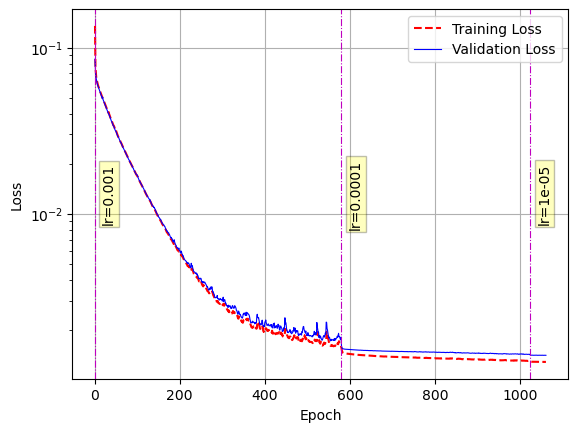

In [43]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 3


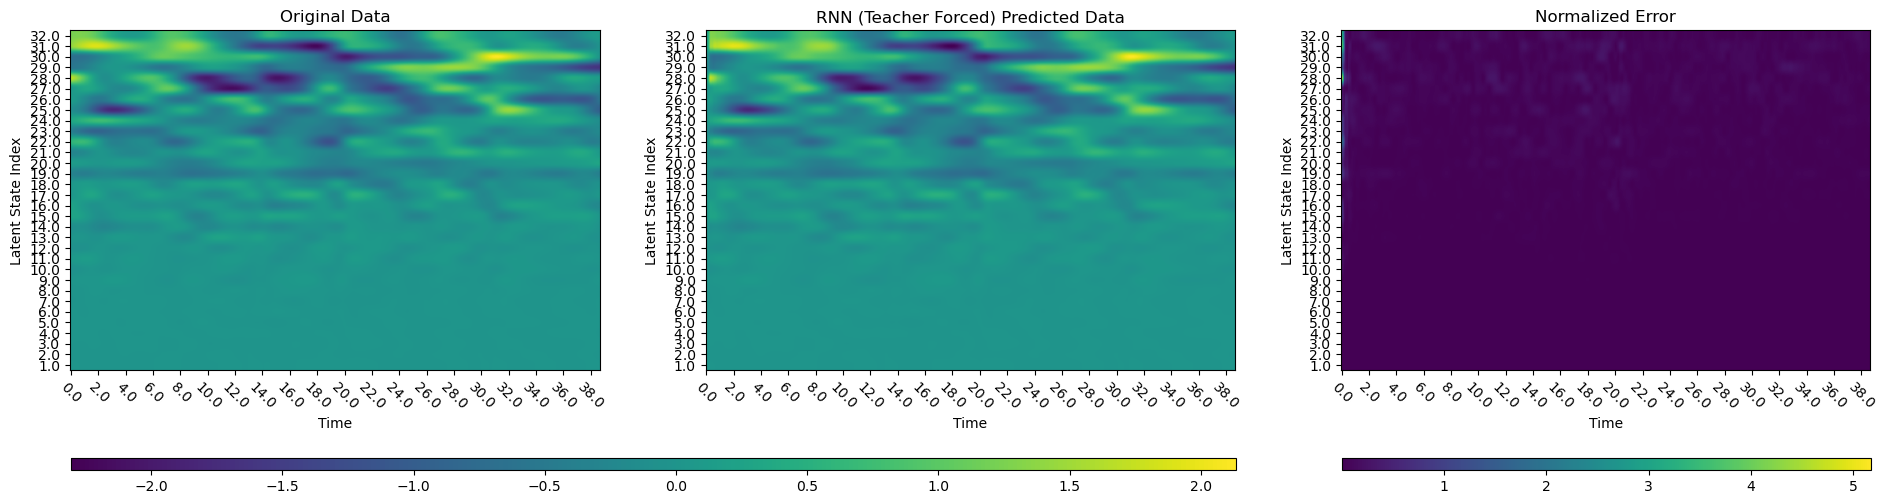

In [45]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_rnn,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [ ]:
prediction.shape, data_out.shape